<div >
<img src = "../banner.jpg" />
</div>

# Superlearners 

In [1]:
require("pacman")
p_load("rmutil")
p_load("tidyverse")
p_load("nnls")
p_load("earth")
p_load("gam")
p_load("data.table")
p_load("SuperLearner")

# set the seed for reproducibility
set.seed(123)
# generate the observed data
n = 1000
x = runif(n, 0, 8)
y = 5 + 4 * sqrt(9 * x) * as.numeric(x <
    2) + as.numeric(x >= 2) * (abs(x - 6)^(2)) +
    rlaplace(n)
D <- data.frame(x, y) # observed data


Loading required package: pacman



In [2]:
xl <- seq(0, 8, 0.1)
yl <- 5 + 4 * sqrt(9 * xl) * as.numeric(xl <
    2) + as.numeric(xl >= 2) * (abs(xl -
    6)^(2))

Dl <- data.frame(xl, yl) # for plotting the true dose-respon


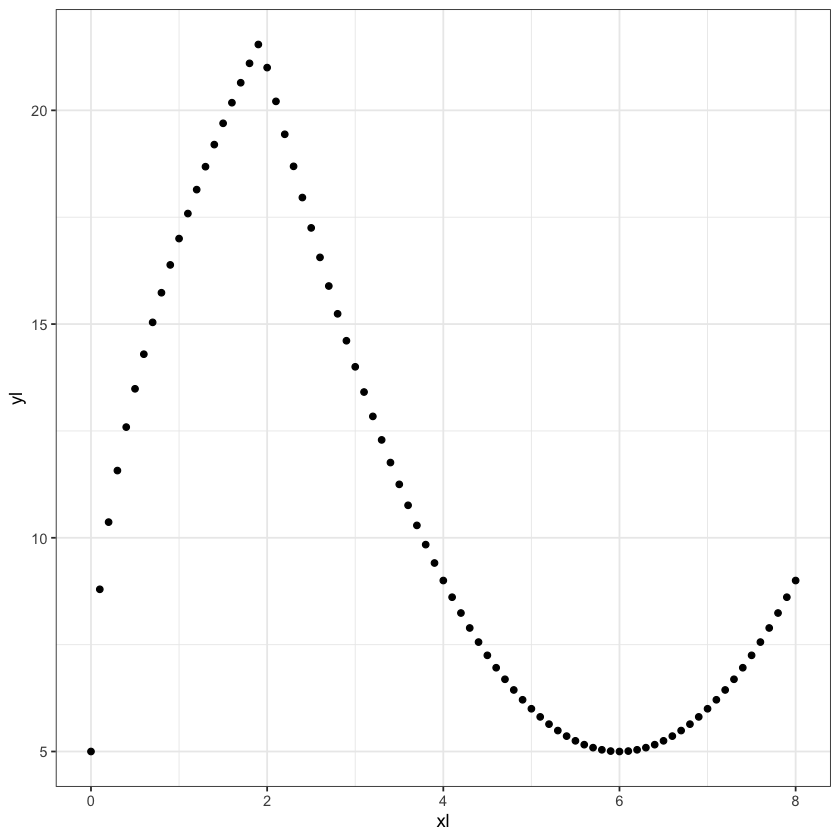

In [3]:
ggplot(Dl) +
  geom_point(aes(x=xl,y=yl))+
  theme_bw()

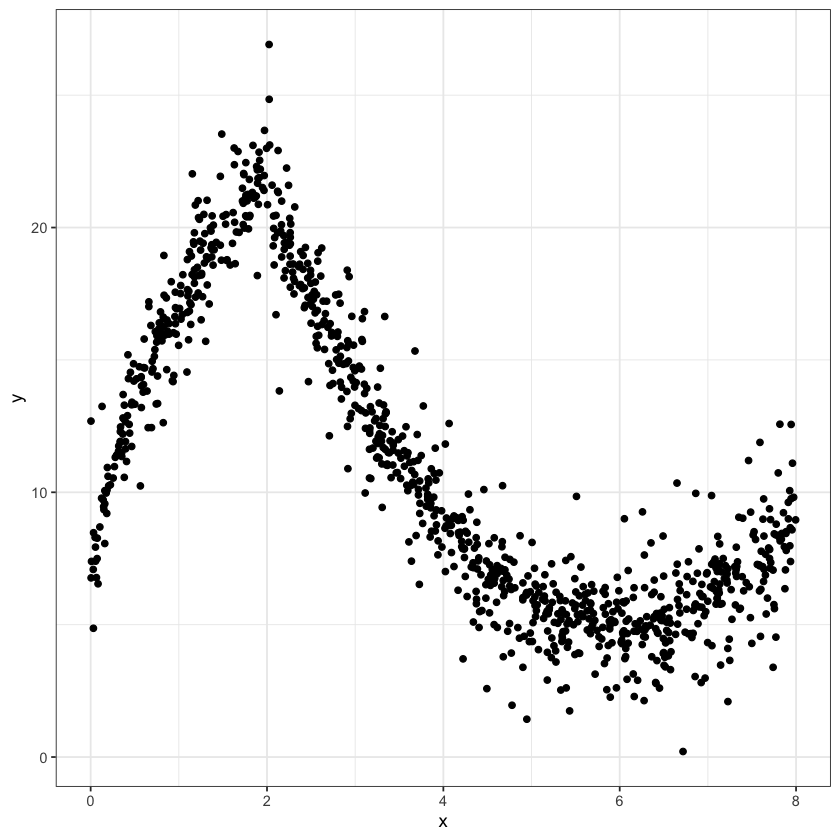

In [4]:
ggplot(D) +
  geom_point(aes(x=x,y=y))+
  theme_bw()

In [5]:
folds = 5
## split data into 5 groups for 5-fold ## cross-validation we do this here so ## that the exact same folds will be ## used in both the SL fit with the R ## package, and the hand coded SL 
index <- split(1:1000, 1:folds)
splt <- lapply(1:folds, function(ind) D[index[[ind]], ])
# view the first 6 observations in the # first [[1]] and second [[2]] folds 
head(splt[[1]])

,x,y
,<dbl>,<dbl>
1,2.300620,18.082553
6,0.364452,12.199149
11,7.654667,7.659093
16,7.198600,7.229326
21,7.116315,6.165418
26,5.668244,4.659275


In [6]:
head(splt[[2]])

,x,y
,<dbl>,<dbl>
2,6.306441,5.301833
7,4.224844,8.943891
12,3.626673,10.249762
17,1.968702,21.964325
22,5.542427,6.089999
27,4.352528,7.891969


In [7]:
# Fit using the SuperLearner Package

In [8]:


SL.gam.5 <- create.Learner("SL.gam", params = list(deg.gam =5))

# Specifying the SuperLearner library # of candidate algorithms
sl.lib <- c(SL.gam.5$names, "SL.earth")


set.seed(123)
fitY <- SuperLearner(Y = y, X = data.frame(x),
    method = "method.NNLS", SL.library  = sl.lib,
    cvControl = list(V = folds, validRows = index))

# View the output: 'Risk' column returns the CV-MSE estimates
# 'Coef' column gives the weights # for the final SuperLearner

fitY



Call:  
SuperLearner(Y = y, X = data.frame(x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                 Risk      Coef
SL.gam_1_All 2.446902 0.3379264
SL.earth_All 2.309112 0.6620736

In [9]:
# Now predict the outcome for all

yS <- predict(fitY, newdata = data.frame(x = xl), onlySL = T)$pred


Dl1 <- data.frame(xl, yS)

# Hand-coding Super Learner


In [10]:
m1 <- lapply(1:folds, function(ii) gam(y ~s(x, 5), family = "gaussian", data = rbindlist(splt[-ii]))) 

In [11]:
m2 <- lapply(1:folds, function(ii) earth(y ~
    x, data = rbindlist(splt[-ii]), degree = 2,
    penalty = 3, nk = 21, pmethod = "backward",
    nfold = 0, ncross = 1, minspan = 0, endspan = 0))

In [12]:
p1 <- lapply(1:folds, function(ii) predict(m1[[ii]], newdata = rbindlist(splt[ii]), type = "response"))
p2 <- lapply(1:folds, function(ii) predict(m2[[ii]], newdata = rbindlist(splt[ii]), type = "response"))
# add the predictions to grouped # dataset 'splt'
for (i in 1:folds) {
    splt[[i]] <- cbind(splt[[i]], p1[[i]],
        p2[[i]])
}

In [19]:
# Risks
risk1 <- lapply(1:folds, function(ii) mean((splt[[ii]][,
    2] - splt[[ii]][, 3])^2))
risk2 <- lapply(1:folds, function(ii) mean((splt[[ii]][, 2] - splt[[ii]][, 4])^2))

                
## 3: average the estimated risks across the 5 folds to obtain 1

a <- rbind(cbind("gam", mean(do.call(rbind,
    risk1), na.rm = T)), cbind("earth", mean(do.call(rbind,
    risk2), na.rm = T)))
a

gam,2.4469015494432
earth,2.30911178845962


In [20]:
# checking to see match with SL output
fitY


Call:  
SuperLearner(Y = y, X = data.frame(x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                 Risk      Coef
SL.gam_1_All 2.446902 0.3379264
SL.earth_All 2.309112 0.6620736

In [14]:
X <- data.frame(do.call(rbind, splt))[, -1] 
names(X) <- c("y", "gam", "earth")
head(X)

,y,gam,earth
,<dbl>,<dbl>,<dbl>
1,18.082553,18.315169,19.529790
6,12.199149,12.705405,11.722377
11,7.659093,7.570780,7.866627
16,7.229326,6.527277,6.541223
21,6.165418,6.355935,6.302089
26,4.659275,4.993494,4.934016


In [15]:
SL.r <- nnls(cbind(X[, 2], X[, 3]), X[, 1])$x
alpha <- as.matrix(SL.r/sum(SL.r))
round(alpha, 3)

0.338
0.662


In [16]:
fitY


Call:  
SuperLearner(Y = y, X = data.frame(x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                 Risk      Coef
SL.gam_1_All 2.446902 0.3379264
SL.earth_All 2.309112 0.6620736

In [17]:
m1 <- gam(y ~ s(x, 5), family = "gaussian", data = D)
m2 <- earth(y ~ x, data = D, degree = 2, penalty = 3, nk = 21, pmethod = "backward", nfold = 0, ncross = 1, minspan = 0, endspan = 0)



## SL function
p1 <- predict(m1, newdata = data.frame(x = xl), type = "response")
p2 <- predict(m2, newdata = data.frame(x = xl), type = "response")
predictions <- cbind(p1, p2)
yS2 <- predictions %*% alpha

In [18]:
Dl2 <- data.frame(xl, yS2,yS)
head(Dl2)

,xl,yS2,yS
,<dbl>,<dbl>,<dbl>
1,0.0,8.972475,8.972475
2,0.1,9.823825,9.823825
3,0.2,10.674687,10.674687
4,0.3,11.523978,11.523978
5,0.4,12.370240,12.370240
6,0.5,13.211791,13.211791
